In [1]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-05 09:51:13.043005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 09:51:13.073059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746420673.110479   14166 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746420673.120895   14166 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 09:51:13.159330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
data = pd.read_csv("processed_deepfake_urdu.csv")
labels = np.where(data["class"] == "Spoofed", 1, 0)

In [3]:
data.head()

,file_path,class,speaker,original_file_id
0,processed_data/Bonafide_Speaker_01_317_seg0.wav,Bonafide,Speaker_01,317
1,processed_data/Bonafide_Speaker_01_317_seg1.wav,Bonafide,Speaker_01,317
2,processed_data/Bonafide_Speaker_01_317_seg2.wav,Bonafide,Speaker_01,317
3,processed_data/Bonafide_Speaker_01_707_seg0.wav,Bonafide,Speaker_01,707
4,processed_data/Bonafide_Speaker_01_707_seg1.wav,Bonafide,Speaker_01,707


In [4]:
TARGET_SR = 16000  
N_MELS = 128       
FIXED_FRAMES = 128 

In [5]:
def extract_spectrogram(file_path, n_fft=2048, hop_length=512, n_mels=128):
    audio, sr = librosa.load(file_path, sr=TARGET_SR)
    
    # Pad audio if too short for n_fft
    if len(audio) < n_fft:
        pad_width = n_fft - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')
    
    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Ensure fixed shape (truncate or pad)
    if mel_db.shape[1] > FIXED_FRAMES:
        mel_db = mel_db[:, :FIXED_FRAMES]
    elif mel_db.shape[1] < FIXED_FRAMES:
        mel_db = np.pad(mel_db, ((0, 0), (0, FIXED_FRAMES - mel_db.shape[1])), mode='constant')

    return mel_db.reshape(n_mels, FIXED_FRAMES, 1)


In [6]:
spectrograms = []
for file in data["file_path"]:
    try:
        spectrogram = extract_spectrogram(file)
        spectrograms.append(spectrogram)
        print(f"Successfully processed file: {file}")  # Debugging statement
    except Exception as e:
        print(f"Error processing file {file}: {e}")

Successfully processed file: processed_data/Bonafide_Speaker_01_317_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_317_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_317_seg2.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_707_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_707_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_260_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_260_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_671_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_671_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_671_seg2.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_504_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_504_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_273_seg0.wav

In [7]:
spectrograms = np.array(spectrograms)

In [ ]:
def plot_spectrograms(spectrograms, labels, num_to_plot=4, sample_rate=16000, hop_length=1024, n_fft=2048):

    # Ensure we don't plot more spectrograms than available
    num_to_plot = min(num_to_plot, spectrograms.shape[0])
    
    # Set up the plot with subplots (2x2 grid for 4 spectrograms)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()  # Flatten axes for easy iteration
    
    # Calculate time and frequency axes
    time_frames = spectrograms.shape[2] if spectrograms.ndim == 3 else spectrograms.shape[1]
    time_axis = np.arange(time_frames) * hop_length / sample_rate  # Time in seconds
    freq_bins = spectrograms.shape[1] if spectrograms.ndim == 3 else spectrograms.shape[0]
    freq_axis = np.linspace(0, sample_rate / 2, freq_bins)  # Frequency in Hz (up to Nyquist)
    
    for i in range(num_to_plot):
        spectrogram = spectrograms[i]
        
        # Plot spectrogram as a heatmap
        im = axes[i].imshow(
            spectrogram,
            aspect='auto',
            origin='lower',
            cmap='viridis',
            interpolation='nearest'
        )
        
        # Set labels and title
        class_label = 'Spoofed' if labels[i] == 1 else 'Bonafide'
        axes[i].set_title(f'Spectrogram {i+1} ({class_label})')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Frequency (Hz)')
        
        # Set x-axis ticks in seconds
        axes[i].set_xticks(np.linspace(0, time_frames-1, 5))
        axes[i].set_xticklabels(np.round(np.linspace(0, time_axis[-1], 5), 2))
        
        # Set y-axis ticks in Hz (assuming linear frequency bins)
        axes[i].set_yticks(np.linspace(0, freq_bins-1, 5))
        axes[i].set_yticklabels(np.round(np.linspace(0, freq_axis[-1], 5), 0).astype(int))
        
        # Add colorbar for amplitude (assuming dB scale)
        plt.colorbar(im, ax=axes[i], label='Amplitude (dB)')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [13]:
# plot_spectrograms(spectrograms, labels)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.3, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [19]:
model = models.Sequential([
    layers.Input(shape=(N_MELS, 128, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-01-26 19:03:12.439005: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=16,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Epoch 1/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 285s 314ms/step - accuracy: 0.5496 - loss: 0.6822 - val_accuracy: 0.6201 - val_loss: 0.6328
Epoch 2/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 322s 354ms/step - accuracy: 0.6084 - loss: 0.6419 - val_accuracy: 0.6912 - val_loss: 0.5761
Epoch 3/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 299s 329ms/step - accuracy: 0.6633 - loss: 0.5782 - val_accuracy: 0.6693 - val_loss: 0.5836
Epoch 4/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 277s 305ms/step - accuracy: 0.7183 - loss: 0.5214 - val_accuracy: 0.7256 - val_loss: 0.5020
Epoch 5/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 246s 271ms/step - accuracy: 0.7306 - loss: 0.5087 - val_accuracy: 0.7440 - val_loss: 0.4708
Epoch 6/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 271s 298ms/step - accuracy: 0.7564 - loss: 0.4587 - val_accuracy: 0.7337 - val_loss: 0.4842
Epoch 7/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 313s 345ms/step - accuracy: 0.7858 - loss: 0.4222 - val_accuracy: 0.7646 - val_loss: 0.4447
Epoch 8/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 250s 276ms/step - accuracy: 0.8395 -

In [22]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=["Bonafide", "Spoofed"]))


98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step
              precision    recall  f1-score   support

    Bonafide       0.86      0.89      0.88      1515
     Spoofed       0.89      0.86      0.88      1594

    accuracy                           0.88      3109
   macro avg       0.88      0.88      0.88      3109
weighted avg       0.88      0.88      0.88      3109



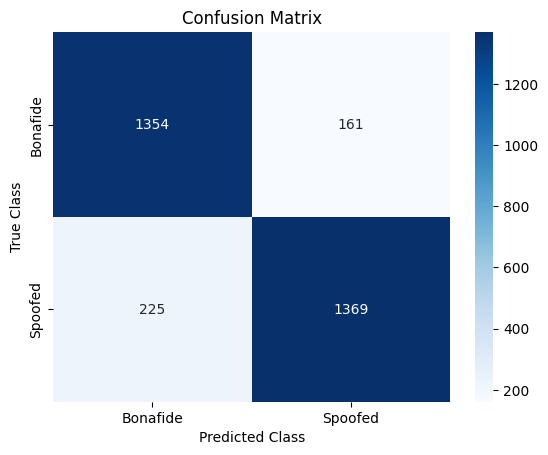

In [23]:
# Define class labels
class_labels = ["Bonafide", "Spoofed"]

# plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


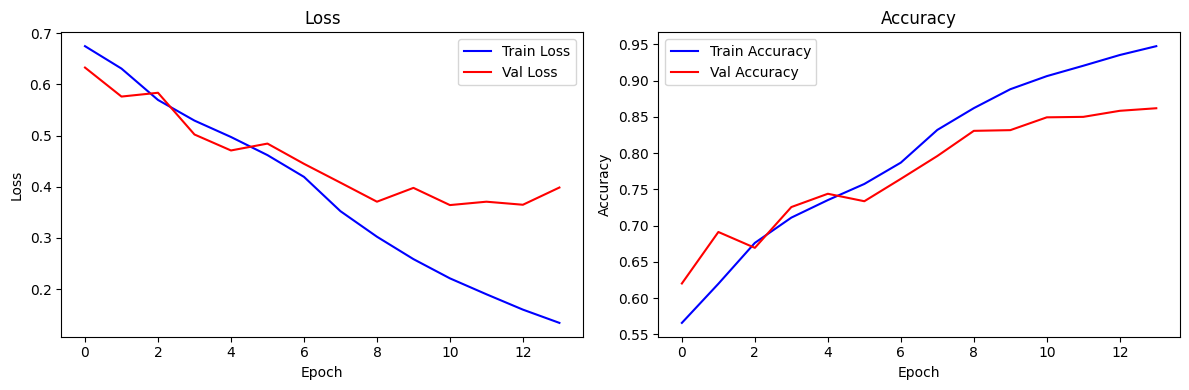

In [24]:
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss", color="blue")
plt.plot(history.history["val_loss"], label="Val Loss",color="red")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy",color="blue")
plt.plot(history.history["val_accuracy"], label="Val Accuracy",color="red")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
model.save("cnn_spectro.h5")